## SOM (Self Organizing Maps) o Redes de Kohonen

https://towardsdatascience.com/self-organizing-maps-for-dimension-reduction-data-visualization-and-clustering-ff966edd311c


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as patches

In [2]:
class FuncInicializarExcep(Exception):
    print("No esta implementada esta funcion de inicialización")
class FuncDistanciaExcep(Exception):
    print("No esta implementada esta distancia")

No esta implementada esta funcion de inicialización
No esta implementada esta distancia


In [3]:
class Kojonen():
    """
    La red esta formada por dos capas de neuronas, la primera tiene
    "entradas" neuronas que debe con el flatten de la entrada y la 
    segunda esta formada por "clusters" neuronas que corresponden a
    las salidas que queremos.
    Las entradas es conveniente que esten escaladas
    Inputs:
    -------
        - canales: numero de canales de la imagen o numero de caracteristicas
        - cluster: numero de clusters a generar: tupla(filas,columnas)
    """

    def __init__(self, canales, clusters, n_iterations, learning_rate,
                 radio=None, distancia='euclidean', f_inicial='normal'):
        # definicion de las capas de entrada y salida
        self.netH, self.netW = clusters
        self.C = canales
        # parametros
        self.distancia = distancia
        self.f_inicial = f_inicial
        self.lr = learning_rate
        self.ni = n_iterations
        if radio is None:
            self.radio = max(self.netH, self.netW) / 2
        self.time_constant = n_iterations / np.log(self.radio)
        # inicializacion
        self.weights = self._inicializar(f_inicial)

    def _inicializar(self, function):
        if function == 'normal':
            return np.random.rand(self.netH, self.netW, self.C)
        elif function == 'zeros':
            return np.zeros((self.netH, self.netW, self.C))
        else:
            raise FuncInicializarExcep()

    def _BMU(self, dato):  # dato.shape(1,1,3)
        """
        Devuelve una tupla con la posicion (m.n) de la neurona que 
        menor distancia tiene a los datos (BMU, best matching unit)
        """
        if self.distancia == 'euclidean':
            # dist(dato-Weights)
            d = np.empty_like(self.weights)
            d[:, :] = dato.flatten()
            distancias = np.linalg.norm(d - self.weights, axis=-1)
        elif self.distancia == 'manhattan':
            # dist(dato-Weights)
            d = np.empty_like(self.weights)
            d[:, :] = dato.flatten()
            distancias = np.linalg.norm(d - self.weights, ord=1, axis=-1)
        else:
            raise FuncDistanciaExcep()

        return np.unravel_index(np.argmin(distancias), shape=(self.netH, self.netW))

    def _neighborhoodDecay(self, iteracion):
        return self.radio * np.exp(-iteracion/self.time_constant)

    def _learningrateDecay(self, iteracion):
        return self.lr * np.exp(-iteracion/self.time_constant)

    def _getNeighborhood(self, bmu, Rd):
        """
        Devuelve la lista de tuplas de posiciones de las neuronas que 
        esta a menos de la distancia Rd
        """
        neighbors = []
        pmax = np.array(bmu)
        for h in range(self.netH):
            for w in range(self.netW):
                d = np.linalg.norm(np.array([h, w]) - pmax)
                if d <= Rd:  # si es menor hay que actualizar la neurona
                    neighbors.append((h, w))
        return neighbors

    def fit(self, dato, iteracion):
        """
        Dado un pixel de la imagen dato.shape=(1,1,canales) actualiza los
        weights de las neuronas. Es necesario pasar iteracion para los decay
        del radio y learning rate
        """
        bmu = self._BMU(dato)  # es una tupla
        Rd = self._neighborhoodDecay(iteracion)
        neighbors = self._getNeighborhood(bmu, Rd)
        neighbors.append(bmu)  # se actualizan BMU y los vecinos
        for neighborH, neighborW in neighbors:
            distance = np.linalg.norm(np.array([neighborH, neighborW]) - np.array(bmu))
            n_t = np.exp(-distance**2/(2*Rd**2))
            l_t = self._learningrateDecay(iteracion)
            # actualizar
            self.weights[neighborH, neighborW] += n_t * l_t * (dato.flatten() - self.weights[neighborH, neighborW])

    def predict(self, dato):
        """
        Calcula para cada pixel que neurona es la mas cercana y le 
        asigna el valor. Dato.shape=(m,n,canales)
        """
        resultado = np.empty_like(dato)
        d = np.empty_like(self.weights)
        for h in range(dato.shape[0]):
            for w in range(dato.shape[1]):
                d[:, :] = dato[h, w]
                resultado[h, w] = self.weights[np.unravel_index(np.argmin(np.linalg.norm(d - self.weights,
                                                                                         axis=-1)),
                                                                shape=(self.netH, self.netW))]
        return resultado

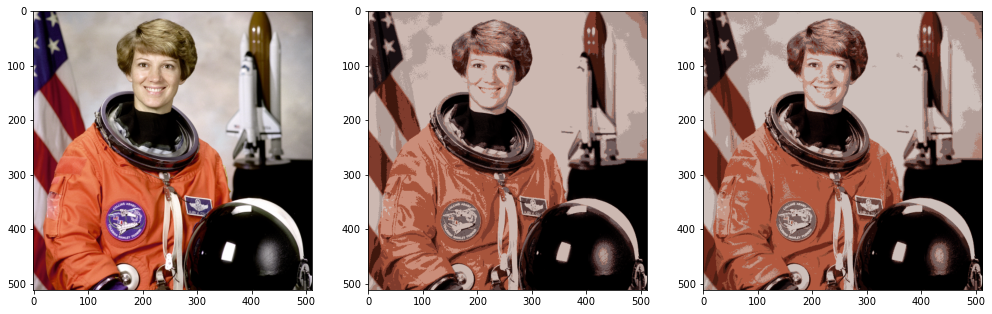

In [4]:
from skimage import data
datos = data.astronaut()/255
fig, ax = plt.subplots(1,3, figsize=(17,7))
ax[0].imshow(datos)

n_iterations = 1000
k = Kojonen(canales=3, clusters=(5,5), n_iterations=n_iterations, learning_rate=0.01,
            f_inicial='zeros')
for i in range(n_iterations):
    aleatorio = datos[np.random.randint(0, datos.shape[0]),np.random.randint(0, datos.shape[1]),:]
    k.fit(aleatorio, i)

ax[1].imshow(k.predict(datos))

n_iterations = 1000
k = Kojonen(canales=3, clusters=(5,5), n_iterations=n_iterations, learning_rate=0.01,
            f_inicial='zeros', distancia='manhattan')
for i in range(n_iterations):
    aleatorio = datos[np.random.randint(0, datos.shape[0]),np.random.randint(0, datos.shape[1]),:]
    k.fit(aleatorio, i)

ax[2].imshow(k.predict(datos))

In [ ]:
## Evolucion de los pesos

In [42]:
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

k = Kojonen(canales=3, clusters=(2,2), n_iterations=n_iterations, learning_rate=0.01,
            f_inicial='zeros')
fig, ax = plt.subplots()
im = ax.imshow(k.weights, animated=True)

datos = data.astronaut()/255
n_iterations = 1000

def animate_func(i):
    aleatorio = datos[np.random.randint(0, datos.shape[0]),np.random.randint(0, datos.shape[1]),:]
    k.fit(aleatorio, i)
    im.set_array(k.weights)
    return [im]

anim = animation.FuncAnimation(fig, func=animate_func, frames=n_iterations, interval=10)
plt.close()
anim
#plt.show()

C:\Users\master\anaconda3\envs\kera\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 